<a href="https://colab.research.google.com/github/ratama98/isyaratku-colab-repository/blob/main/IsyaratKu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isyaratku

### Import Libraries

In [ ]:
import tensorflow as tf
import tensorflow.lite as tflite
import cv2
import numpy as np
import pandas as pd
import sklearn
import string
import shutil
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import os

In [ ]:
!pip install kaggle

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Use GPU If available

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

Num GPUs Available:  1


## ASL

### Import Data

In [ ]:
os.makedirs('asl_9', exist_ok=True)
os.makedirs('asl_11', exist_ok=True)

In [ ]:
!kaggle datasets download -d ayuraj/asl-dataset
!kaggle datasets download -d ameythakur20/asl-alphabet-train
!kaggle datasets download -d danrasband/asl-alphabet-test
!kaggle datasets download -d jeyasrisenthil/hand-signs-asl-hand-sign-data
!kaggle datasets download -d yashudaykulkarni/asl-alphabet-new-test
!kaggle datasets download -d ysjprojects/asl-signs
!kaggle datasets download -d nasrinsulthana/asl-recognition
!kaggle datasets download -d pradiptomondal/aslalphabets
!kaggle datasets download -d jayprakashgiri/asl-dataset -p asl_9
!kaggle datasets download -d mayank0bhardwaj/alphabets
!kaggle datasets download -d angelgortiz/american-sign-language -p asl_11

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
asl-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/ameythakur20/asl-alphabet-train
License(s): unknown
asl-alphabet-train.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/danrasband/asl-alphabet-test
License(s): CC0-1.0
asl-alphabet-test.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/jeyasrisenthil/hand-signs-asl-hand-sign-data
License(s): DbCL-1.0
hand-signs-asl-hand-sign-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/yashudaykulkarni/asl-alphabet-new-test
License(s): unknown
asl-alphabet-new-test.zip: Skipping, found more recently modified local copy (use -

In [ ]:
!mkdir ./datasets
!rm -rf sample_data

!unzip -o /kaggle/working/asl-dataset.zip -d datasets/asl_1
!unzip -o asl-alphabet-train.zip -d datasets/asl_2
!unzip -o asl-alphabet-test.zip -d datasets/asl_3
!unzip -o hand-signs-asl-hand-sign-data.zip -d datasets/asl_4
!unzip -o asl-alphabet-new-test.zip -d datasets/asl_5
!unzip -o asl-signs.zip -d datasets/asl_6
!unzip -o asl-recognition.zip -d datasets/asl_7
!unzip -o aslalphabets.zip -d datasets/asl_8
!unzip -o /kaggle/working/asl_9/asl-dataset.zip -d datasets/asl_9
!unzip -o alphabets.zip -d datasets/asl_10
!unzip -o /kaggle/working/asl_11/american-sign-language.zip -d datasets/asl_11

clear_output()

In [ ]:
!ls -al ./datasets/

total 52
drwxr-xr-x 13 root root 4096 Jun 19 12:42 .
drwxr-xr-x  6 root root 4096 Jun 19 12:42 ..
drwxr-xr-x  3 root root 4096 Jun 19 12:42 asl_1
drwxr-xr-x  3 root root 4096 Jun 19 12:42 asl_10
drwxr-xr-x  3 root root 4096 Jun 19 12:42 asl_11
drwxr-xr-x  3 root root 4096 Jun 19 12:42 asl_2
drwxr-xr-x 32 root root 4096 Jun 19 12:42 asl_3
drwxr-xr-x  3 root root 4096 Jun 19 12:42 asl_4
drwxr-xr-x  3 root root 4096 Jun 19 12:42 asl_5
drwxr-xr-x  3 root root 4096 Jun 19 12:42 asl_6
drwxr-xr-x 31 root root 4096 Jun 19 12:42 asl_7
drwxr-xr-x  4 root root 4096 Jun 19 12:42 asl_8
drwxr-xr-x  3 root root 4096 Jun 19 12:42 asl_9


### Data Preparation and Exploration

In [ ]:
data_1 = '/kaggle/working/datasets/asl_1/asl_dataset'
data_2 = '/kaggle/working/datasets/asl_2/asl-alphabet-train'
data_3 = '/kaggle/working/datasets/asl_3'
data_4 ='/kaggle/working/datasets/asl_4/DATASET'
data_5 = '/kaggle/working/datasets/asl_5/asl-alphabet-test'
data_6 = '/kaggle/working/datasets/asl_6/dataset'
data_7 = '/kaggle/working/datasets/asl_7'
data_8 ='/kaggle/working/datasets/asl_8/image_dataset/train'
data_9 = '/kaggle/working/datasets/asl_8/image_dataset/valid'
data_10 = '/kaggle/working/datasets/asl_9/data/train'
data_11 = '/kaggle/working/datasets/asl_10/generated images'
data_12 = '/kaggle/working/datasets/asl_11'

In [ ]:
def rename_blank(dataset):
    data_old = dataset
    data_parent = os.path.dirname(data_old)
    data_new = os.path.join(data_parent, 'space')
    os.rename(data_old, data_new)

In [ ]:
def rename_to_uppercase(dataset):
    for name in os.listdir(dataset):
        subfolder = os.path.join(dataset, name)
        if os.path.isdir(subfolder) and name.islower():
            new_name = name.upper()
            new_subfolder = os.path.join(dataset, new_name)
            os.rename(subfolder, new_subfolder)

In [ ]:
def preprocess (dir):
  letter = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
  letter.add('nothing')
  for name in os.listdir(dir):
    subfolder = os.path.join(dir, name)
    if os.path.isdir(subfolder) and name not in letter:
        shutil.rmtree(subfolder)

  asl_label = {}
  x=0
  for folder in sorted(os.listdir(dir)):
    asl_label[x] = folder
    x+=1

  return asl_label

In [ ]:
def load_and_label_images(images_path, label_dict):
    X = []
    y = []
    for key, value in label_dict.items():
        path = os.path.join(images_path, value)
        print(value, key)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (200, 200))
            X.append(new_array)
            y.append(key)
    return X, y

In [ ]:
rename_to_uppercase(data_1)
rename_to_uppercase(data_12)

In [ ]:
blank_6 = '/kaggle/working/datasets/asl_6/dataset/BLANK'
blank_10 = '/kaggle/working/datasets/asl_10/generated images/NIL'
rename_blank(blank_6)
rename_blank(blank_10)

In [ ]:
mapping_1 = preprocess(data_1)
mapping_2 = preprocess(data_2)
mapping_3 = preprocess(data_3)
mapping_4 = preprocess(data_4)
mapping_5 = preprocess(data_5)
mapping_6 = preprocess(data_6)
mapping_7 = preprocess(data_7)
mapping_8 = preprocess(data_8)
mapping_9 = preprocess(data_9)
mapping_10 = preprocess(data_10)
mapping_11 = preprocess(data_11)
mapping_12 = preprocess(data_12)

In [ ]:
images_1, label_1 = load_and_label_images(data_1, mapping_1)
images_2, label_2 = load_and_label_images(data_2, mapping_2)
images_3, label_3 = load_and_label_images(data_3, mapping_3)
images_4, label_4 = load_and_label_images(data_4, mapping_4)
images_5, label_5 = load_and_label_images(data_5, mapping_5)
images_6, label_6 = load_and_label_images(data_6, mapping_6)
images_7, label_7 = load_and_label_images(data_7, mapping_7)
images_8, label_8 = load_and_label_images(data_8, mapping_8)
images_9, label_9 = load_and_label_images(data_9, mapping_9)
images_10, label_10 = load_and_label_images(data_10, mapping_10)
images_11, label_11 = load_and_label_images(data_11, mapping_11)
images_12, label_12 = load_and_label_images(data_12, mapping_12)

clear_output()

In [ ]:
images = images_1 + images_2 + images_3 + images_4 + images_5 + images_6 + images_7 + images_8 + images_9 + images_10 + images_11 + images_12
labels = label_1 + label_2 + label_3 + label_4 + label_5 + label_6 + label_7 + label_8 + label_9 + label_10 + label_11 + label_12

In [ ]:
print(len(images))
print(len(labels))

32181
32181


#### Split dataset

In [ ]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)

In [ ]:
images_train=np.array(images_train)
labels_train=np.array(labels_train)

print(images_train.shape)
print(labels_train.shape)

(28962, 200, 200, 3)
(28962,)


In [ ]:
images_test=np.array(images_test)
labels_test=np.array(labels_test)

print(images_test.shape)
print(labels_test.shape)

(3219, 200, 200, 3)
(3219,)


In [ ]:
labels_train[0]

10

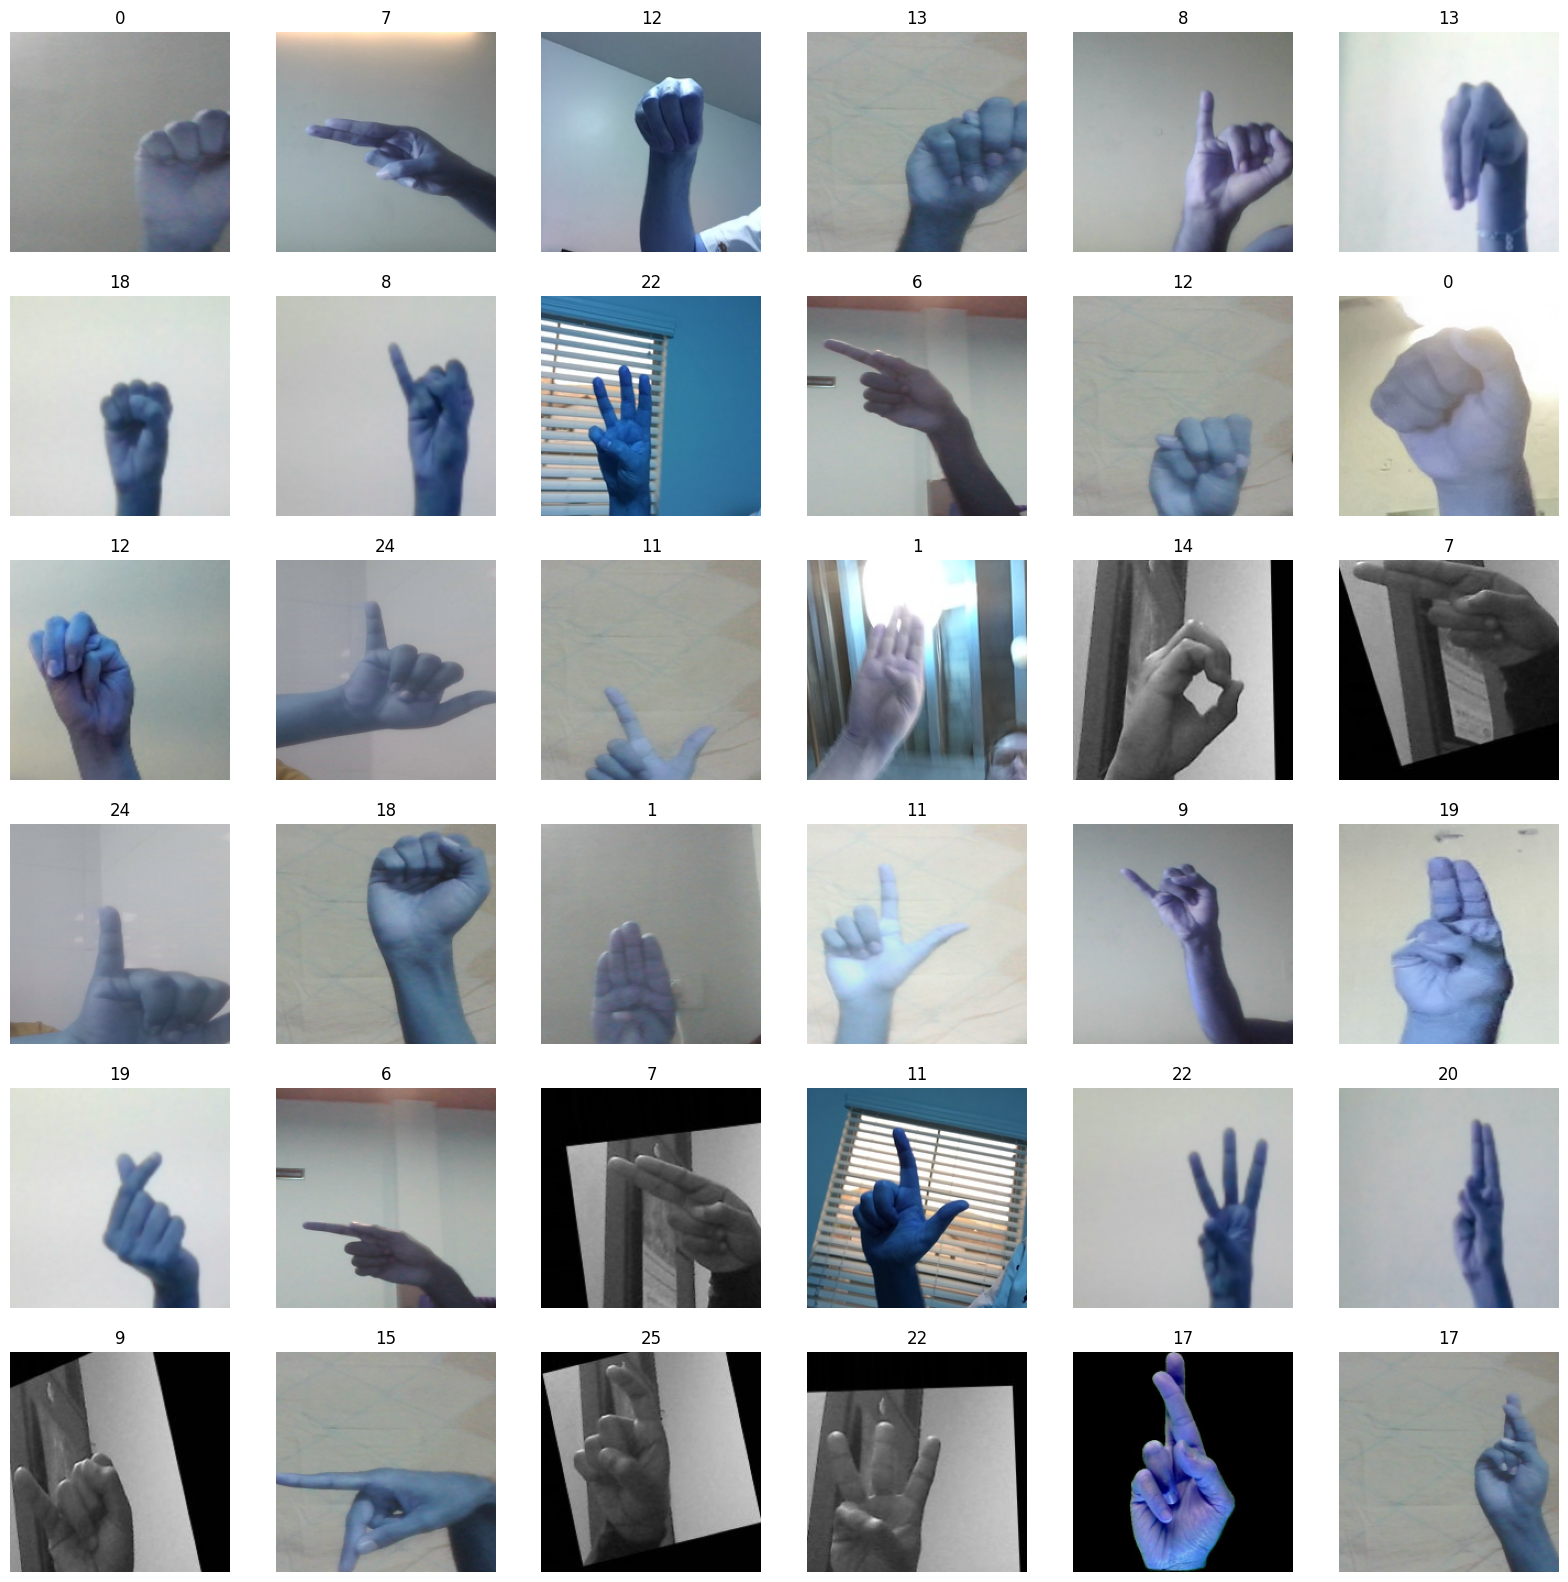

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(images_train),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(images_train[i])
    plt.axis('off')
    plt.title(labels_train[i])

### Build Sequential Model Architecture


In [ ]:
 model = Sequential([
        tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(200,200,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(27, activation='softmax')
  ])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 196, 196, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 196, 196, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,771 (2.10 MB)

 Trainable params: 551,451 (2.10 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Configure and Train Model

In [ ]:
history = model.fit(images_train, labels_train, epochs=60, validation_data=(images_test, labels_test))

Epoch 1/60
906/906 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1220 - loss: 3.2854

W0000 00:00:1718804496.949262     358 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


906/906 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.1220 - loss: 3.2850 - val_accuracy: 0.2513 - val_loss: 2.5583
Epoch 2/60
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3891 - loss: 2.0796 - val_accuracy: 0.4343 - val_loss: 1.9894
Epoch 3/60
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5497 - loss: 1.5304 - val_accuracy: 0.5825 - val_loss: 1.4237
Epoch 4/60
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6133 - loss: 1.3035 - val_accuracy: 0.6831 - val_loss: 1.0864
Epoch 5/60
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6686 - loss: 1.1018 - val_accuracy: 0.6415 - val_loss: 1.1598
Epoch 6/60
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7001 - loss: 1.0036 - val_accuracy: 0.7723 - val_loss: 0.8035
Epoch 7/60
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7238 - loss: 0.9251 - val_accuracy: 0.7459 - val_loss: 0.8423
Epoch 8/60
906/906 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7453 - loss: 0.8351 - val_accurac

### Review Training Curves and Metrics

In [ ]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f"Accuracy: {accuracy*100:.2f} %")

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9163 - loss: 0.3189
Accuracy: 90.18 %


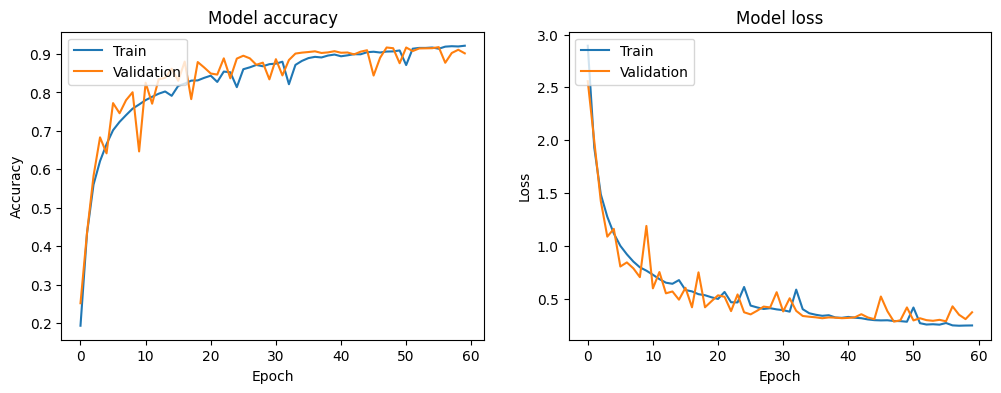

In [ ]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

In [ ]:
labels_pred = model.predict(images_test)
labels_pred = [np.argmax(i) for i in labels_pred]

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Text(0.5, 135.7222222222222, 'Predicted Labels')

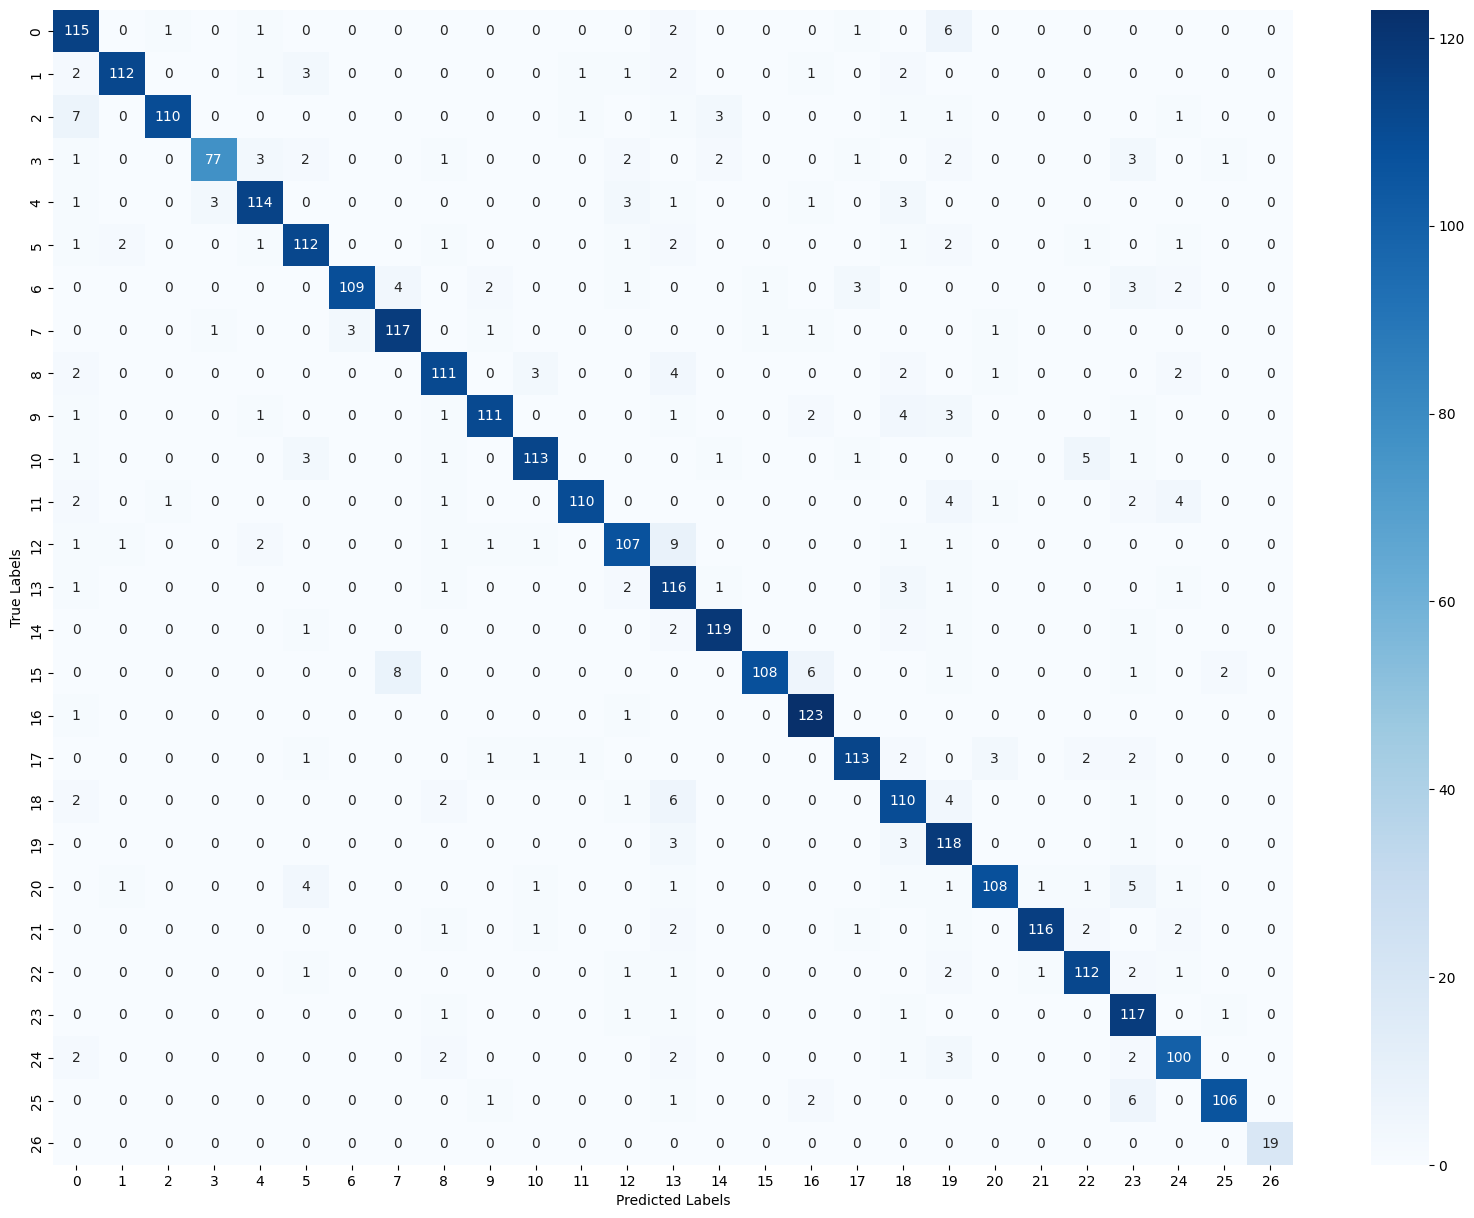

In [ ]:
import seaborn as sns
from tensorflow.math import confusion_matrix

plt.figure(figsize=(20,15))
sns.heatmap(confusion_matrix(labels_test, labels_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       126
           1       0.97      0.90      0.93       125
           2       0.98      0.88      0.93       125
           3       0.95      0.81      0.87        95
           4       0.93      0.90      0.92       126
           5       0.88      0.90      0.89       125
           6       0.97      0.87      0.92       125
           7       0.91      0.94      0.92       125
           8       0.90      0.89      0.89       125
           9       0.95      0.89      0.92       125
          10       0.94      0.90      0.92       126
          11       0.97      0.88      0.92       125
          12       0.88      0.86      0.87       125
          13       0.74      0.92      0.82       126
          14       0.94      0.94      0.94       126
          15       0.98      0.86      0.92       126
          16       0.90      0.98      0.94       125
          17       0.94    

### Convert Model

In [ ]:
model.save('asl_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('asl_model.tflite', 'wb') as f:
    f.write(tflite_model)

## BISINDO

In [ ]:
!pip install keras_tuner

In [ ]:
from tensorflow.keras import layers
import keras_tuner as kt
from tqdm import tqdm

import seaborn as sns
from tensorflow.math import confusion_matrix

from sklearn.metrics import classification_report

### Data Preparation and Exploration

In [ ]:
images_train = '/content/datasets/indonesian-sign-language-bisindo/bisindo/images/train'
labels_train = '/content/datasets/indonesian-sign-language-bisindo/bisindo/labels/train'

images_test = '/content/datasets/indonesian-sign-language-bisindo/bisindo/images/val'
labels_test = '/content/datasets/indonesian-sign-language-bisindo/bisindo/labels/val'

In [ ]:
def dataset(dir):
  path = []

  for letter in os.listdir(dir):
    letter_dir = os.path.join(dir, letter)

    for name in os.listdir(letter_dir):
      path.append(os.path.join(letter_dir, name))
  return path

In [ ]:
b_images_train = dataset(images_train)
b_labels_train = dataset(labels_train)

b_images_test = dataset(images_test)
b_labels_test = dataset(labels_test)

In [ ]:
print(f'There are {len(b_images_train)} images for training')
print(f'There are {len(b_labels_train)} labels for training')
print(f'There are {len(b_images_test)} images for test')
print(f'There are {len(b_labels_test)} labels for test')

There are 9169 images for training
There are 9168 labels for training
There are 2301 images for test
There are 2301 labels for test


### Try without the given label

In [ ]:
folders = sorted(os.listdir(images_train))
label_dict = {i: folder for i, folder in enumerate(folders)}
print(label_dict)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [ ]:
def load_and_label_images(images_path, label_dict):
    X = []
    y = []
    for key, value in label_dict.items():
        path = os.path.join(images_path, value)
        print(value, key)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (200,200))
            X.append(new_array)
            y.append(key)
    return X, y

X_train, y_train = load_and_label_images(images_train, label_dict)
X_test, y_test = load_and_label_images(images_test, label_dict)

A 0


100%|██████████| 350/350 [00:03<00:00, 87.52it/s]


B 1


100%|██████████| 351/351 [00:06<00:00, 50.61it/s]


C 2


100%|██████████| 343/343 [00:05<00:00, 65.38it/s]


D 3


100%|██████████| 348/348 [00:05<00:00, 66.18it/s]


E 4


100%|██████████| 352/352 [00:07<00:00, 44.71it/s]


F 5


100%|██████████| 357/357 [00:04<00:00, 72.90it/s]


G 6


100%|██████████| 360/360 [00:07<00:00, 51.39it/s]


H 7


100%|██████████| 348/348 [00:02<00:00, 150.57it/s]


I 8


100%|██████████| 360/360 [00:02<00:00, 154.37it/s]


J 9


100%|██████████| 360/360 [00:02<00:00, 156.30it/s]


K 10


100%|██████████| 348/348 [00:02<00:00, 118.39it/s]


L 11


100%|██████████| 357/357 [00:03<00:00, 118.58it/s]


M 12


100%|██████████| 355/355 [00:02<00:00, 149.30it/s]


N 13


100%|██████████| 350/350 [00:02<00:00, 149.31it/s]


O 14


100%|██████████| 357/357 [00:02<00:00, 154.45it/s]


P 15


100%|██████████| 357/357 [00:02<00:00, 152.40it/s]


Q 16


100%|██████████| 348/348 [00:03<00:00, 97.35it/s] 


R 17


100%|██████████| 350/350 [00:02<00:00, 153.79it/s]


S 18


100%|██████████| 343/343 [00:02<00:00, 144.15it/s]


T 19


100%|██████████| 360/360 [00:02<00:00, 146.40it/s]


U 20


100%|██████████| 355/355 [00:02<00:00, 154.01it/s]


V 21


100%|██████████| 357/357 [00:03<00:00, 96.21it/s]


W 22


100%|██████████| 360/360 [00:02<00:00, 143.96it/s]


X 23


100%|██████████| 355/355 [00:02<00:00, 155.41it/s]


Y 24


100%|██████████| 328/328 [00:02<00:00, 142.46it/s]


Z 25


100%|██████████| 360/360 [00:02<00:00, 148.22it/s]


A 0


100%|██████████| 88/88 [00:00<00:00, 104.80it/s]


B 1


100%|██████████| 88/88 [00:01<00:00, 82.77it/s]


C 2


100%|██████████| 86/86 [00:00<00:00, 88.79it/s]


D 3


100%|██████████| 87/87 [00:01<00:00, 83.06it/s]


E 4


100%|██████████| 89/89 [00:01<00:00, 74.55it/s]


F 5


100%|██████████| 90/90 [00:01<00:00, 88.41it/s]


G 6


100%|██████████| 90/90 [00:00<00:00, 90.12it/s] 


H 7


100%|██████████| 87/87 [00:00<00:00, 153.84it/s]


I 8


100%|██████████| 90/90 [00:00<00:00, 149.35it/s]


J 9


100%|██████████| 90/90 [00:00<00:00, 153.73it/s]


K 10


100%|██████████| 87/87 [00:00<00:00, 148.66it/s]


L 11


100%|██████████| 90/90 [00:00<00:00, 145.98it/s]


M 12


100%|██████████| 89/89 [00:00<00:00, 156.00it/s]


N 13


100%|██████████| 88/88 [00:00<00:00, 144.71it/s]


O 14


100%|██████████| 90/90 [00:00<00:00, 147.15it/s]


P 15


100%|██████████| 90/90 [00:00<00:00, 163.38it/s]


Q 16


100%|██████████| 87/87 [00:00<00:00, 144.39it/s]


R 17


100%|██████████| 88/88 [00:00<00:00, 151.84it/s]


S 18


100%|██████████| 86/86 [00:00<00:00, 147.46it/s]


T 19


100%|██████████| 90/90 [00:00<00:00, 148.89it/s]


U 20


100%|██████████| 89/89 [00:00<00:00, 158.70it/s]


V 21


100%|██████████| 90/90 [00:00<00:00, 149.33it/s]


W 22


100%|██████████| 90/90 [00:00<00:00, 148.17it/s]


X 23


100%|██████████| 89/89 [00:00<00:00, 117.20it/s]


Y 24


100%|██████████| 83/83 [00:00<00:00, 88.50it/s]


Z 25


100%|██████████| 90/90 [00:00<00:00, 93.63it/s]


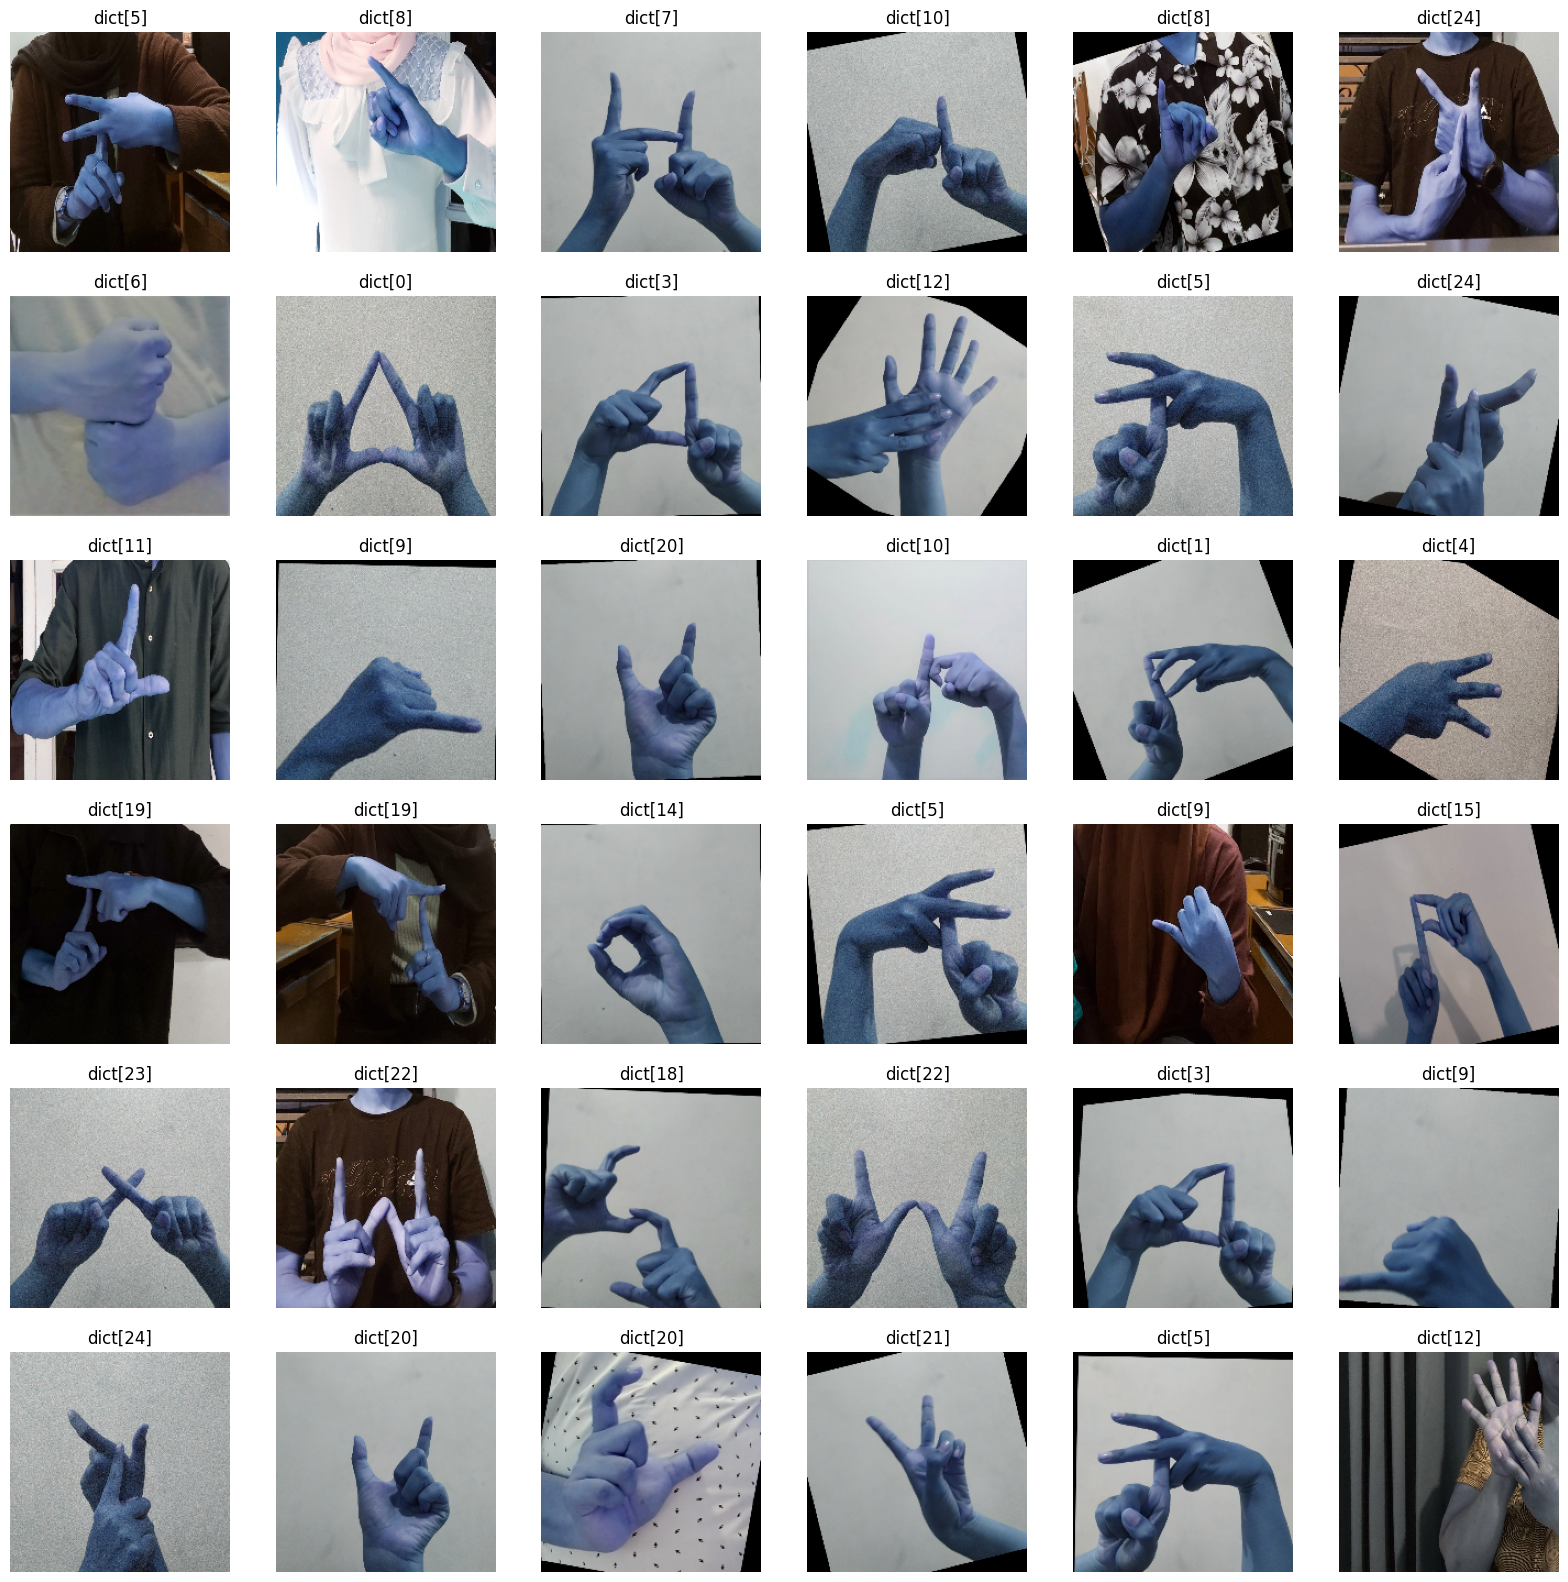

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(dict[y_train[i]])

In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(9169, 200, 200, 3)
(9169,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(7335, 200, 200, 3)
(1834, 200, 200, 3)
(7335,)
(1834,)


In [ ]:
X_test=np.array(X_test)
y_test=np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(2301, 200, 200, 3)
(2301,)


### Build and Create Base Model

### Build Sequential Model Architecture


In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
base_model.trainable = False

bisindo_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(200, 200, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(26, activation='softmax')
    ])

bisindo_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = bisindo_model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=128,
    validation_data=(X_val, y_val)
)

Epoch 1/35
58/58 [==============================] - 32s 221ms/step - loss: 3.5746 - accuracy: 0.1742 - val_loss: 4.8753 - val_accuracy: 0.1112
Epoch 2/35
58/58 [==============================] - 11s 187ms/step - loss: 1.9227 - accuracy: 0.5377 - val_loss: 2.1624 - val_accuracy: 0.3839
Epoch 3/35
58/58 [==============================] - 11s 182ms/step - loss: 1.3593 - accuracy: 0.6545 - val_loss: 0.9867 - val_accuracy: 0.7415
Epoch 4/35
58/58 [==============================] - 11s 183ms/step - loss: 1.0910 - accuracy: 0.7099 - val_loss: 0.7694 - val_accuracy: 0.7797
Epoch 5/35
58/58 [==============================] - 11s 185ms/step - loss: 0.9463 - accuracy: 0.7388 - val_loss: 1.5050 - val_accuracy: 0.5638
Epoch 6/35
58/58 [==============================] - 11s 182ms/step - loss: 0.8450 - accuracy: 0.7635 - val_loss: 0.9281 - val_accuracy: 0.7263
Epoch 7/35
58/58 [==============================] - 11s 183ms/step - loss: 0.7593 - accuracy: 0.7804 - val_loss: 0.6377 - val_accuracy: 0.8026

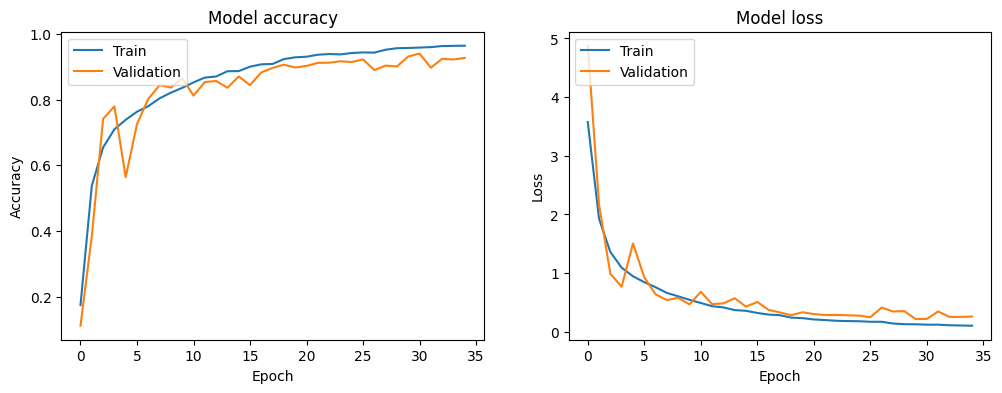

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

### Review Training Curves and Metrics

In [ ]:
loss, accuracy = bisindo_model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f} %")

72/72 [==============================] - 1s 14ms/step - loss: 0.2575 - accuracy: 0.9205
Accuracy: 92.05 %


In [ ]:
y_pred = bisindo_model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]

72/72 [==============================] - 1s 8ms/step


Text(0.5, 135.7222222222222, 'Predicted Labels')

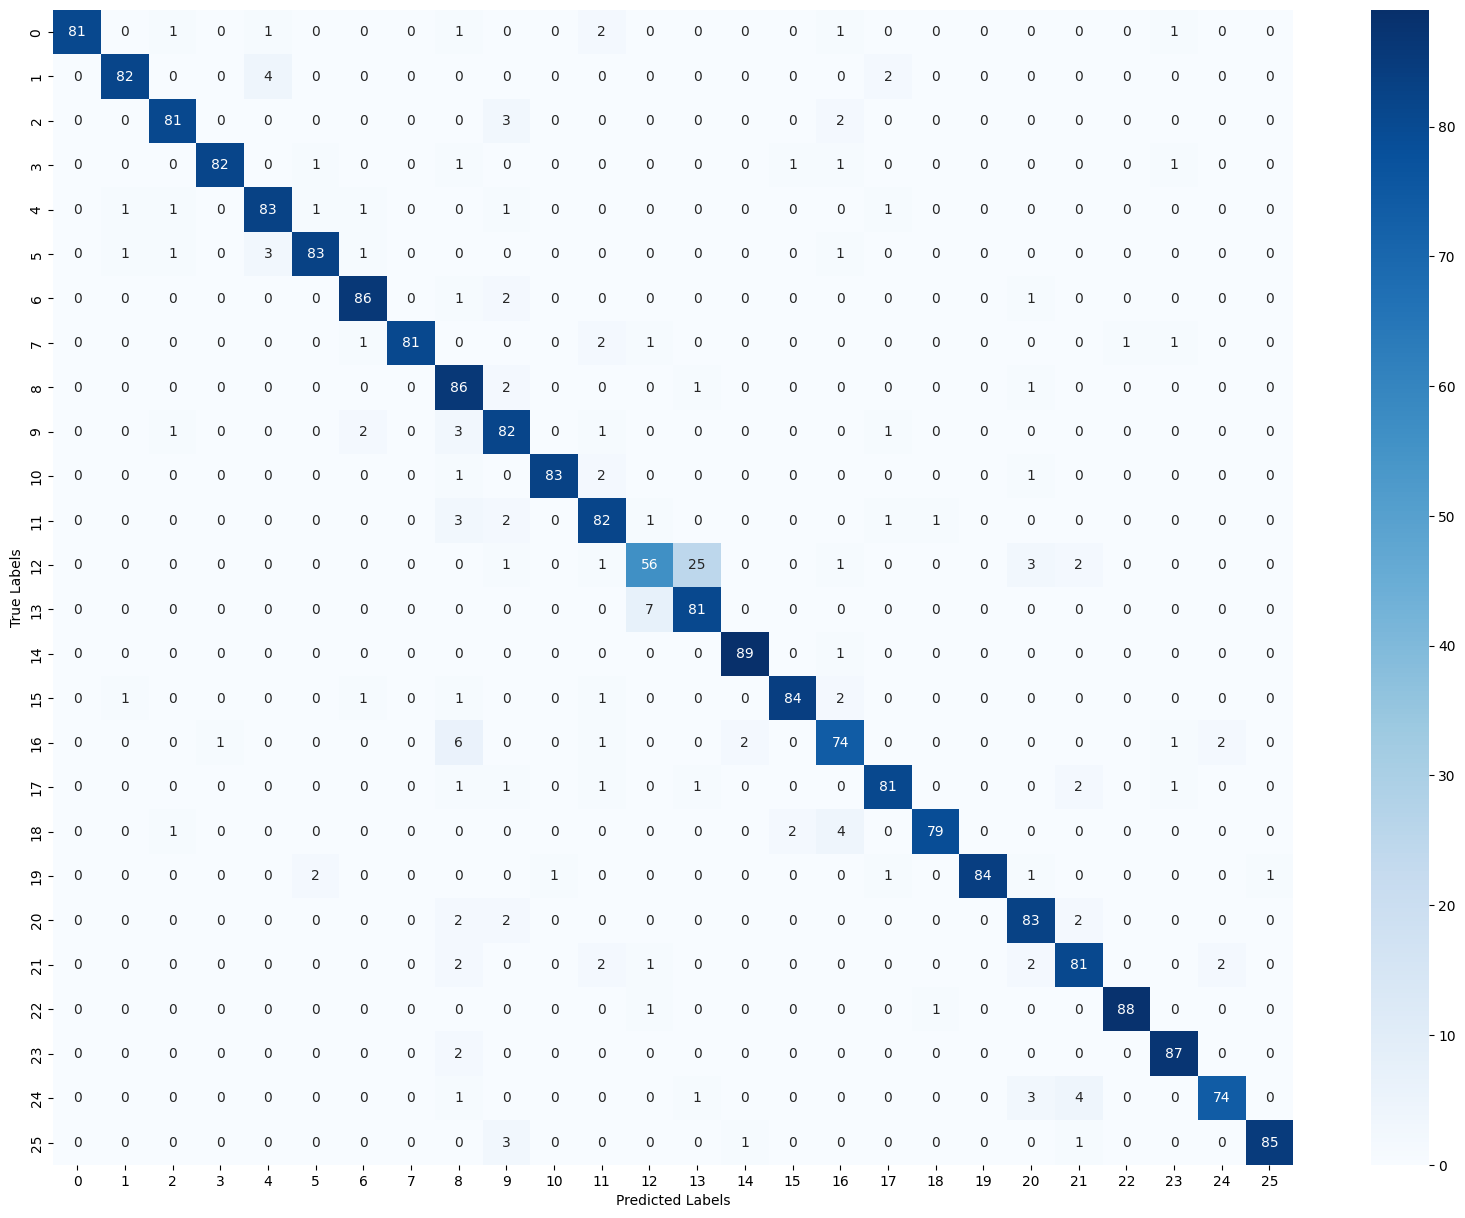

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        88
           1       0.96      0.93      0.95        88
           2       0.94      0.94      0.94        86
           3       0.99      0.94      0.96        87
           4       0.91      0.93      0.92        89
           5       0.95      0.92      0.94        90
           6       0.93      0.96      0.95        90
           7       1.00      0.93      0.96        87
           8       0.77      0.96      0.86        90
           9       0.83      0.91      0.87        90
          10       0.99      0.95      0.97        87
          11       0.86      0.91      0.89        90
          12       0.84      0.63      0.72        89
          13       0.74      0.92      0.82        88
          14       0.97      0.99      0.98        90
          15       0.97      0.93      0.95        90
          16       0.85      0.85      0.85        87
          17       0.93    

### Convert to TFLite

In [ ]:
bisindo_model.save('bisindo_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(bisindo_model)
bisindo_tflite_model = converter.convert()

with open('bisindo_model.tflite', 'wb') as f:
    f.write(bisindo_tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


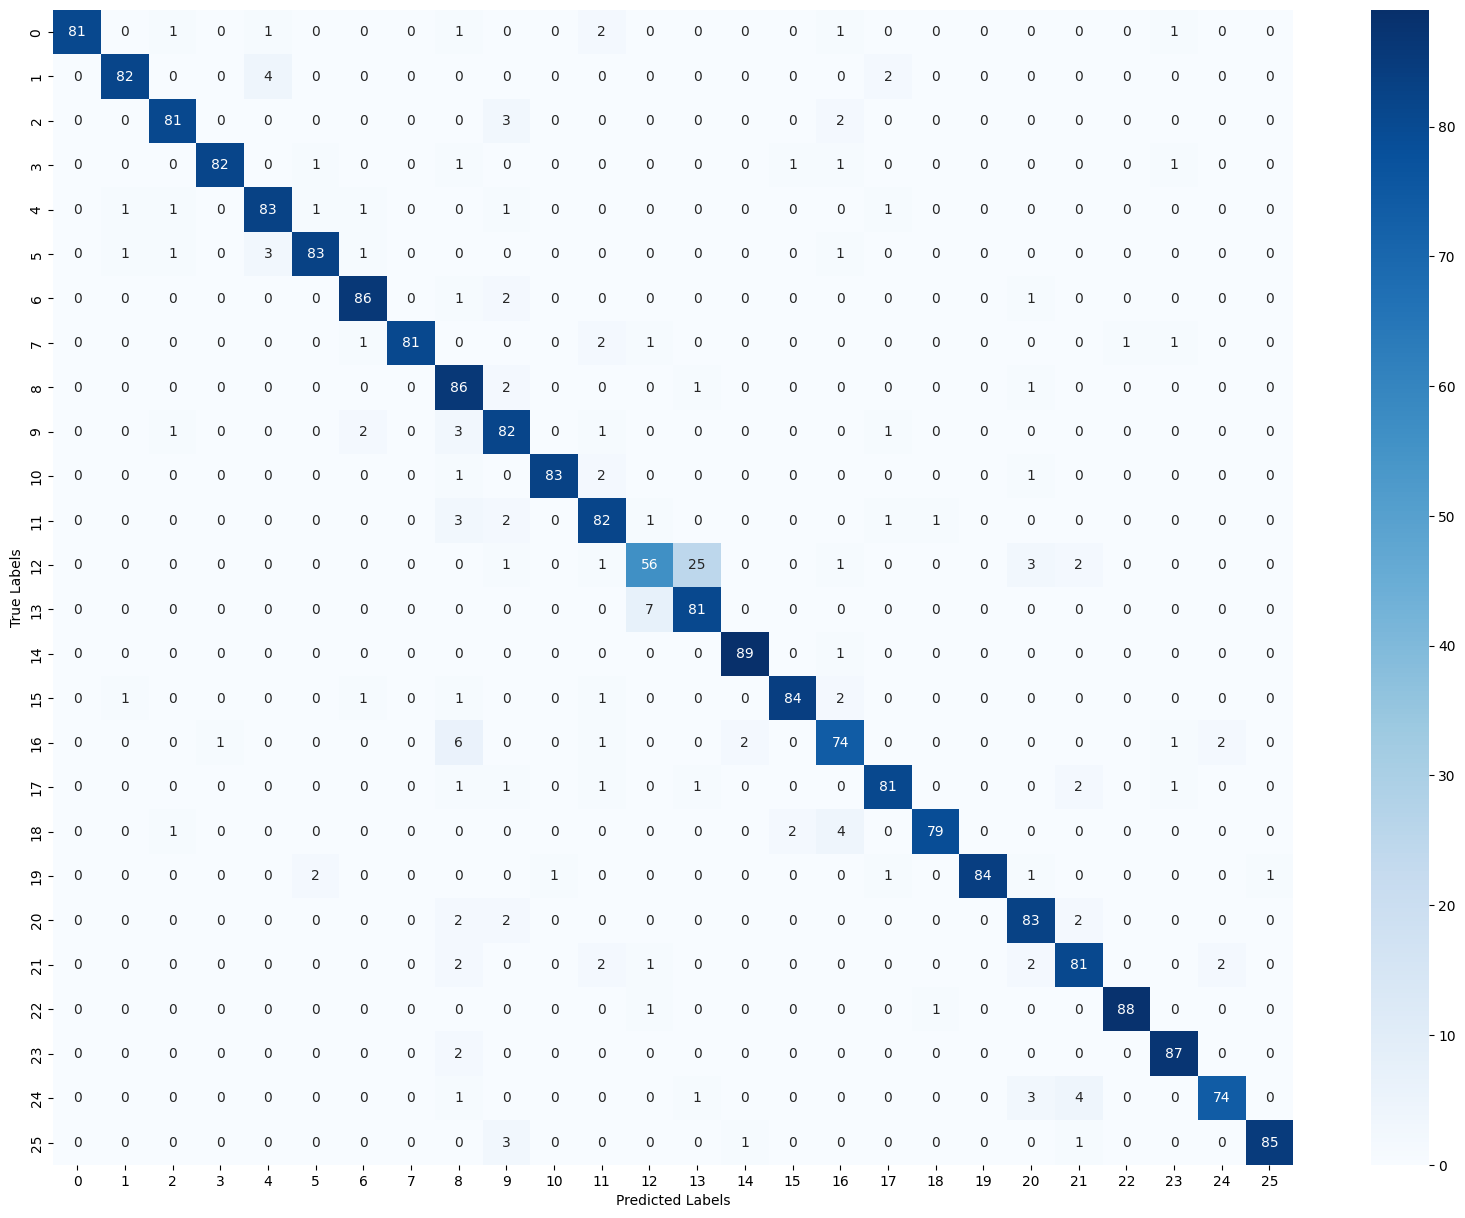

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        88
           1       0.96      0.93      0.95        88
           2       0.94      0.94      0.94        86
           3       0.99      0.94      0.96        87
           4       0.91      0.93      0.92        89
           5       0.95      0.92      0.94        90
           6       0.93      0.96      0.95        90
           7       1.00      0.93      0.96        87
           8       0.77      0.96      0.86        90
           9       0.83      0.91      0.87        90
          10       0.99      0.95      0.97        87
          11       0.86      0.91      0.89        90
          12       0.84      0.63      0.72        89
          13       0.74      0.92      0.82        88
          14       0.97      0.99      0.98        90
          15       0.97      0.93      0.95        90
          16       0.85      0.85      0.85        87
          17       0.93    

In [ ]:
interpreter = tf.lite.Interpreter(model_path="bisindo_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict(interpreter, input_data):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test)

predictions = []
for i in range(len(X_test)):
    test_input = np.expand_dims(X_test[i], axis=0)
    output_data = predict(interpreter, test_input)
    predicted_label = np.argmax(output_data, axis=1)[0]
    predictions.append(predicted_label)

conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

print(class_report)

### Hyperparameter Tuning and Reconfigure Layers

In [ ]:
# def build_model(hp):
#     model = tf.keras.Sequential()

#     model.add(layers.Conv2D(
#         filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
#         kernel_size=hp.Choice('conv_1_kernel_size', values=[3, 5]),
#         activation='relu',
#         input_shape=(200, 200, 3)
#     ))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(4, 4)))
#     model.add(layers.Dropout(0.25))

#     model.add(layers.Conv2D(
#         filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
#         kernel_size=hp.Choice('conv_2_kernel_size', values=[3, 5]),
#         activation='relu'
#     ))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(4, 4)))
#     model.add(layers.Dropout(0.25))

#     model.add(layers.Conv2D(
#         filters=hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
#         kernel_size=hp.Choice('conv_3_kernel_size', values=[3, 5]),
#         activation='relu'
#     ))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(4, 4)))
#     model.add(layers.Dropout(0.25))

#     model.add(layers.Flatten())

#     model.add(layers.Dense(
#         units=hp.Int('dense_units', min_value=128, max_value=1024, step=128),
#         activation='relu'
#     ))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.5))

#     model.add(layers.Dense(26, activation='softmax'))

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(
#             hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#         ),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

In [ ]:
# tuner = kt.Hyperband(
#     build_model,
#     objective='accuracy',
#     max_epochs=35,
#     factor=3,
#     overwrite=True
# )

In [ ]:
# tuner.search(X_train, y_train, epochs=35, batch_size=64)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# bisindo_hps_model = tuner.hypermodel.build(best_hps)

# history = bisindo_hps_model.fit(X_train, y_train, epochs=35, batch_size=64)

### Review Training Curves and Metrics (hyperparameter tuning)

In [ ]:
# loss, accuracy = bisindo_hps_model.evaluate(X_test, y_test)
# print(f"Accuracy: {accuracy*100:.2f} %")

In [ ]:
# y_pred = bisindo_hps_model.predict(X_test)
# y_pred = [np.argmax(i) for i in y_pred]

In [ ]:
# plt.figure(figsize=(20,15))
# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
# plt.ylabel('True Labels')
# plt.xlabel('Predicted Labels')

In [ ]:
# print(classification_report(y_test, y_pred))